# Using Nilearn for analysis of faceWord data in BIDS format

This tutorial is almost identical to tutorial 09 and is based on [this analysis](https://nilearn.github.io/stable/auto_examples/07_advanced/plot_bids_analysis.html).
 and [this analysis](https://nilearn.github.io/dev/auto_examples/00_tutorials/plot_single_subject_single_run.html#sphx-glr-auto-examples-00-tutorials-plot-single-subject-single-run-py) presented on the Nilearn web-page.

NB! A lot of things have been deleted from the original notebook

In [1]:
# Activating environment
!bash env_to_ipynb_kernel.sh

## Second level (group) model estimation

To investigate the degree of overlap in the data, we will perform a 2nd level analysis, where the contrast estimates for each individual participant will enter as data in a new statistical test.

We just have to provide the list of fitted FirstLevelModel objects
to the SecondLevelModel object for estimation. We can do this because
all subjects share a similar design matrix (same variables reflected in
column names).



In [1]:
import pickle
import pandas # modulenotfounderror fixed with pip install "pandas<2.0.0"

f = open('FaceWordData/WordFace_first_level_models.pkl', 'rb')
models, models_run_imgs, models_events, models_confounds = pickle.load(f)

In [2]:
from nilearn.glm.second_level import SecondLevelModel
#We will simply add the models estimated above to the second level

#second_level_input = models

#NB idx11 has different resolution for some reason
second_level_input = models[0:11]+models[12:]

#Adding the smoothing parameter
second_level_model = SecondLevelModel(smoothing_fwhm=8.0)
second_level_model = second_level_model.fit(second_level_input)

print(second_level_model)

/work/Members' Files/SarahHedvigDahlNielsen#8292/env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 6 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")


SecondLevelModel(smoothing_fwhm=8.0)


Note that we apply a smoothing of 8mm.



Computing contrasts at the second level is as simple as at the first level.
Since we are not providing confounders we are performing a one-sample test
at the second level with the images determined by the specified first level
contrast.



In [3]:
# NB, variable names used in contrasts have to be the same as those in events file.
zmap_g = second_level_model.compute_contrast(
    first_level_contrast='image_neg-image_pos')

/work/Members' Files/SarahHedvigDahlNielsen#8292/env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 6 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")
/work/Members' Files/SarahHedvigDahlNielsen#8292/env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 6 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")
/work/Members' Files/SarahHedvigDahlNielsen#8292/env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 6 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")
/work/Members' Files/SarahHedvigDahlNielsen#8292/env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 6 runs
  warn(f"One contrast given, assuming it for a

The group level contrast shows...


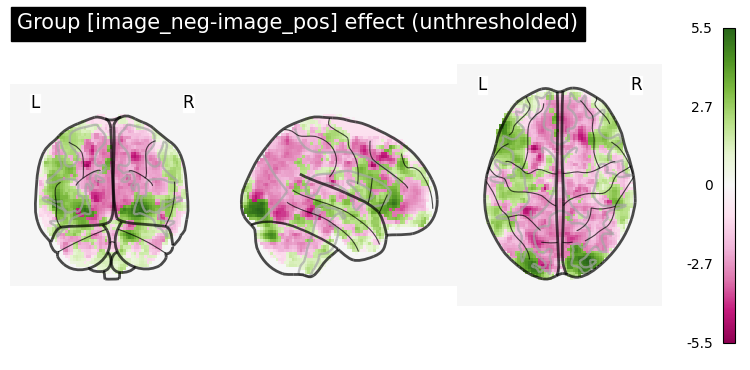

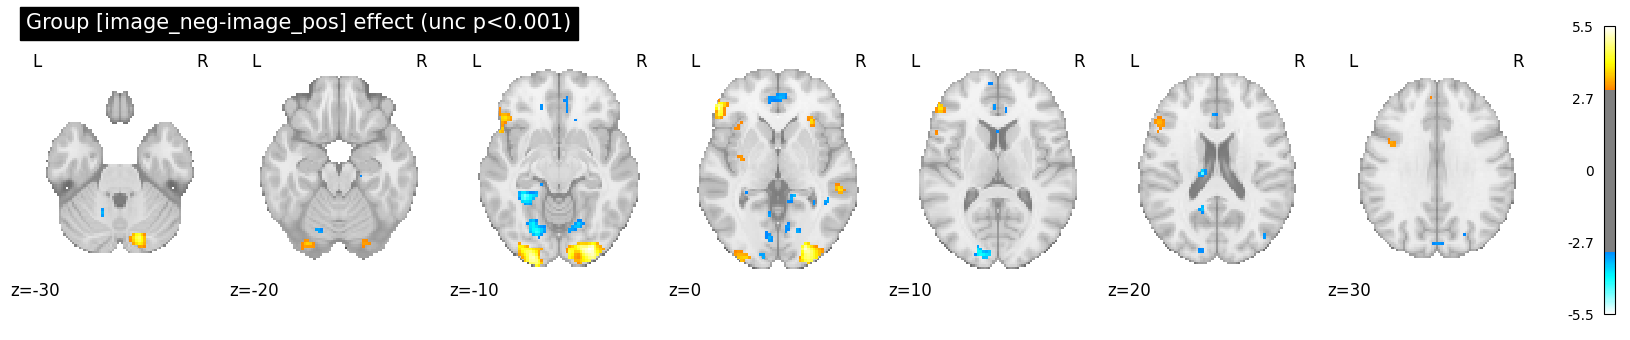

In [25]:
from nilearn.plotting import plot_stat_map, plot_glass_brain
import matplotlib
import matplotlib.pyplot as plt

# Defined earlier in the original
from scipy.stats import norm
p001_unc = norm.isf(0.001)

plot_glass_brain(zmap_g, cmap='PiYG',colorbar=True, threshold=None,
                          title='Group [image_neg-image_pos] effect (unthresholded)',
                          plot_abs=False)
plt.show()

plot_stat_map(zmap_g, cmap='cold_hot',threshold=p001_unc, cut_coords=[-30,-20,-10,0,10,20,30],
              display_mode='z',  black_bg=False,
              title='Group [image_neg-image_pos] effect (unc p<0.001)')
plt.show()

The p<.05 FWER-corrected threshold is 5


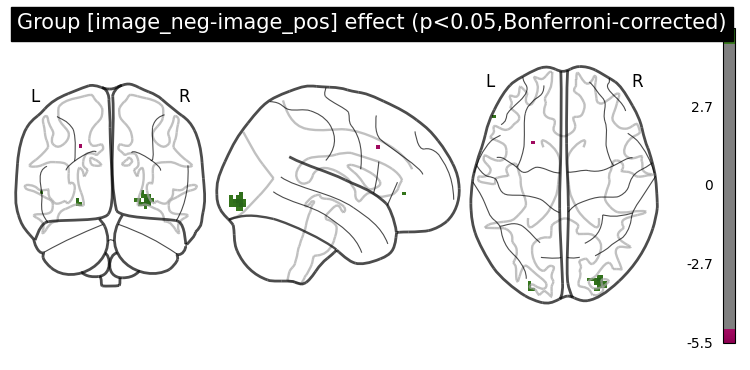

  Cluster ID          X          Y    Z  Peak Stat Cluster Size (mm3)
0          1  27.274001 -89.558000 -9.5   5.499753                574
1         1a  24.748001 -89.558000 -0.5   5.249283                   
2          2 -25.771999 -94.610000 -6.5   5.265843                 95
3          3 -53.558000  36.742002 -0.5   5.079133                 19
4          4  24.748001 -97.136000 -3.5   5.061219                 19


In [14]:
from nilearn.glm import threshold_stats_img
from nilearn.reporting import get_clusters_table

thresholded_map, threshold = threshold_stats_img(
    zmap_g, alpha=0.05, height_control='bonferroni')
print('The p<.05 FWER-corrected threshold is %.3g' % threshold)

plot_glass_brain(zmap_g, cmap='PiYG',colorbar=True, threshold=threshold,
                          title='Group [image_neg-image_pos] effect (p<0.05,Bonferroni-corrected)',
                          plot_abs=False)
plt.show()

# Make a table of cluster coordinates.
table = get_clusters_table(zmap_g, stat_threshold=threshold)
print(table)

### Find anatomical labels for peak activations
We will use a function called [atlasreader](https://github.com/miykael/atlasreader).

In [ ]:
from atlasreader import create_output
import pandas as pd

#create_output(zmap_g, voxel_thresh=threshold, cluster_extent=0,direction='both')
#Atlasreader automatically saves results to both .png-files and a csv-file. Look in your working directory.
atlas = pd.read_csv('atlasreader_peaks.csv')

In [4]:
import pandas as pd

atlas = pd.read_csv('atlasreader_peaks.csv')
atlas.to_excel('output.xlsx', index=False)

ModuleNotFoundError: No module named 'openpyxl'

As can be seen, the fdr correction may be too lenient, and the FWE correction may be too stringent.

## Non-parametric permutation methods for calculating corrected p-values

Based on [this](https://nilearn.github.io/dev/auto_examples/05_glm_second_level/plot_second_level_one_sample_test.html#sphx-glr-auto-examples-05-glm-second-level-plot-second-level-one-sample-test-py) example.

Permutation tests are a class of non-parametric methods. They were pioneered by Fisher (1935) and Pitman (1937). Fisher demonstrated that the null hypothesis could be tested simply by observing, after permuting observations, how often the difference between means would exceed the difference found without permutation, and that for such test, no normality would be required.


![permutation_stats.jpg](images/permutation_stats.jpg)

If we are comparing two samples (e.g. `treatment` and `control`), we can calculate the effect, we get when shuffling the category labels.

![Permutation_test_example_animation.gif](images/Permutation_test_example_animation.gif)
Source:[Wikipedia](https://en.wikipedia.org/wiki/Permutation_test)

The percentage of values we get that are bigger than our original value, represents the probability that our value comes from the null-distribution.

The one-sided p-value of the test is calculated as the proportion of sampled permutations where the difference in means was greater than ${\displaystyle T_{\text{obs}}}$. 
The two-sided p-value of the test is calculated as the proportion of sampled permutations where the absolute difference was greater than 
${\displaystyle |T_{\text{obs}}|}$.

When conducting a one-sample group analysis with fMRI-data, we are testing ${\displaystyle H_{0}:T=0}$, i.e.  if the effect of any given voxel is larger than zero. We can obtain a null-distribution by estimating the effect N times, while randomly flipping the sign on each datapoint.

### Making a an image for comparison
Before we make the permutation test, we'll calculate an image from the parametric analysis for comparison. We will use the negative log of the p-value as a measure.


In [26]:
import numpy as np
from nilearn.image import get_data, math_img

#Get an image of p-values
p_val = second_level_model.compute_contrast(first_level_contrast='image_neg-image_pos',output_type='p_value')
# Get the number of voxels in the image
n_voxels = np.sum(get_data(second_level_model.masker_.mask_img_))
# Making an image with significant values, correcting the p-values for multiple testing and taking negative logarithm
neg_log_pval = math_img(
    '-np.log10(np.minimum(1, img * {}))'.format(str(n_voxels)),
    img=p_val,
)

#Check image shape
print(neg_log_pval.shape)

/opt/conda/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/opt/conda/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/opt/conda/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/opt/conda/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/opt/conda/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One 

(78, 92, 65)


<string>:1: RuntimeWarning: divide by zero encountered in log10


### Next, we perform the permutations.

In [30]:
from nilearn.glm.second_level import non_parametric_inference

now = datetime.now()
print('Starting cell:',now.strftime("%H:%M:%S"))

# n_perm=1000 for the sake of time. Ideally, this should be 10,000, but the upper limit on permutations is 2 to the power of N.
n_perm=10000

#We base the analysis on a contrast image (z-score map) from each participant
second_level_input2=[]
#Put the NIimg zmaps into a list.
for ii in range(21):
    second_level_input2.append(second_level_input[ii].zmap)

design_matrix = pd.DataFrame(
    [1] * len(second_level_input2),
    columns=['intercept'],
)
print(design_matrix)

#Calculate p-values using permutation
out_dict = non_parametric_inference(
    second_level_input2,
    design_matrix=design_matrix,,
    model_intercept=True,
    n_perm=n_perm,  
    two_sided_test=False,
    smoothing_fwhm=8.0,
    n_jobs=1,
        
    
)

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

    intercept
0           1
1           1
2           1
3           1
4           1
5           1
6           1
7           1
8           1
9           1
10          1
11          1
12          1
13          1
14          1
15          1
16          1
17          1
18          1
19          1
20          1


Now let's plot the permutation results and compare with the bonferroni corrected effect. 

Note that effects are now negative log of the p-value, so we will have to take that into consideration when plotting.

/opt/conda/lib/python3.10/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


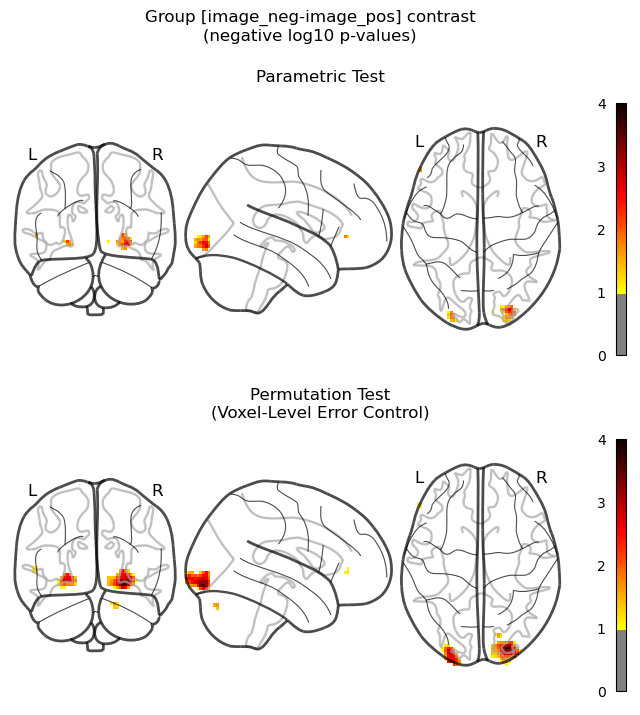

In [32]:

# Prepare thresholds for plotting

threshold_log = round(-np.log10(1 / 20))  # p < 0.05 
vmax = round(-np.log10(1 / n_perm)) # minimal p-value possible with the number of permuations

cut_coords = [0]

#Prepare images to plot
IMAGES = [
    neg_log_pval,
    out_dict
]
TITLES = [
    'Parametric Test',
    'Permutation Test\n(Voxel-Level Error Control)',
]

#Make loop with plots
fig, axes = plt.subplots(figsize=(8, 8), nrows=2, ncols=1)
img_counter = 0
i_row=0
for j_row in range(2):
        ax = axes[j_row]     
        plotting.plot_glass_brain(
            IMAGES[img_counter],
            colorbar=True,
            vmax=vmax,
            plot_abs=False,
            cut_coords=cut_coords,
            threshold=threshold_log,
            figure=fig,
            axes=ax,
        )

        
        ax.set_title(TITLES[img_counter])
        img_counter += 1


fig.suptitle('Group [image_neg-image_pos] contrast\n(negative log10 p-values)')
plt.show()

### Publish!!!

We have a result. We are almost ready for publication. All we need to know is what it means... 

In [ ]:
now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))